In [1]:
import argparse
import os
import random
from copy import deepcopy
from datetime import datetime
from glob import glob
from os import listdir, makedirs
from os.path import basename, exists, isdir, isfile, join
from time import time

import cv2
import numpy as np
from skimage import exposure, io
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, trange

from callback.checkpoint import model_checkpoint
from dataset.encoded_dataset import EncodedDataset
from dataset.npy_dataset import NpyDataset
from evaluation.iou import cal_iou
from evaluation.SurfaceDice import (
    compute_dice_coefficient,
    compute_surface_dice_at_tolerance,
    compute_surface_distances,
)
from loss.default_loss import DefaultLoss
from models.medsam_lite import MedSAM_Lite
from segment_anything.modeling import MaskDecoder, PromptEncoder, TwoWayTransformer
from tiny_vit_sam import TinyViT

import copy
import random
import pandas as pd
from pathlib import Path
import random
from os.path import join, isfile, basename
import numpy as np
import torch
from torch.utils.data import Dataset

import cv2
from pathlib import Path
import pickle

import numpy as np
import albumentations as A


def rle_encode_multivalue(mask):

    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    changes = np.diff(pixels) != 0  # 값이 변경되는 지점 찾기
    indexes = np.where(changes)[0] + 1  # 변경 지점의 인덱스
    runs = [
        (indexes[i], indexes[i + 1] - indexes[i], pixels[indexes[i]])
        for i in range(len(indexes) - 1)
    ]

    return runs


def rle_decode_multivalue(runs, shape):

    img = np.zeros(shape[0] * shape[1], dtype=np.uint16)
    for start, length, value in runs:
        img[start - 1 : start + length - 1] = value
    if np.max(img) < 255:
        img = img.astype(np.uint8)
    return img.reshape(shape)


_modality_list = [
    "CT",
    "Dermoscopy",
    "Endoscopy",
    "Fundus",
    "Mammo",
    "Microscopy",
    "MR",
    "OCT",
    "PET",
    "US",
    "XRay",
    "nuclei",
]

In [2]:
def anisotropic_diffusion(img, num_iter, kappa, gamma=0.1):
    """
    Apply anisotropic diffusion (Perona-Malik filter) to an image.

    Parameters:
        img (numpy.ndarray): The input image (grayscale).
        num_iter (int): Number of iterations to run the diffusion.
        kappa (float): Conductance coefficient, controls diffusion amount.
        gamma (float): Integration constant (small timestep).

    Returns:
        numpy.ndarray: The image after applying anisotropic diffusion.
    """
    # Convert image to float and normalize to range 0-1
    img = img.astype(np.float32) / 255

    # Initialize the output image
    diffused_img = img.copy()

    for i in range(num_iter):
        # Calculate gradients
        north = np.roll(diffused_img, -1, axis=0)
        south = np.roll(diffused_img, 1, axis=0)
        east = np.roll(diffused_img, 1, axis=1)
        west = np.roll(diffused_img, -1, axis=1)

        # Compute differences
        delta_n = north - diffused_img
        delta_s = south - diffused_img
        delta_e = east - diffused_img
        delta_w = west - diffused_img

        # Calculate the diffusion flux
        c_n = np.exp(-((delta_n / kappa) ** 2))
        c_s = np.exp(-((delta_s / kappa) ** 2))
        c_e = np.exp(-((delta_e / kappa) ** 2))
        c_w = np.exp(-((delta_w / kappa) ** 2))

        # Update the image
        diffused_img += gamma * (
            c_n * delta_n + c_s * delta_s + c_e * delta_e + c_w * delta_w
        )
    # Rescale back to 8-bit image values
    return (diffused_img * 255).astype(np.uint8)

In [3]:
data_root = "/data1/inqlee0704/medsam/train/compressed"
batch_size = 1
train_dataset = EncodedDataset(data_root, data_aug=True, mode="train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
batch = next(iter(train_loader))

In [5]:
img = batch["image"][0, 0, :, :]
mask = batch["gt2D"][0, 0, :, :]

In [6]:
x_min = int(batch["bboxes"][0, 0, 0, 0])
y_min = int(batch["bboxes"][0, 0, 0, 1])
x_max = int(batch["bboxes"][0, 0, 0, 2])
y_max = int(batch["bboxes"][0, 0, 0, 3])
patch_img = img[y_min : y_max + 1, x_min : x_max + 1]
patch_min = torch.min(patch_img)
patch_max = torch.max(patch_img)

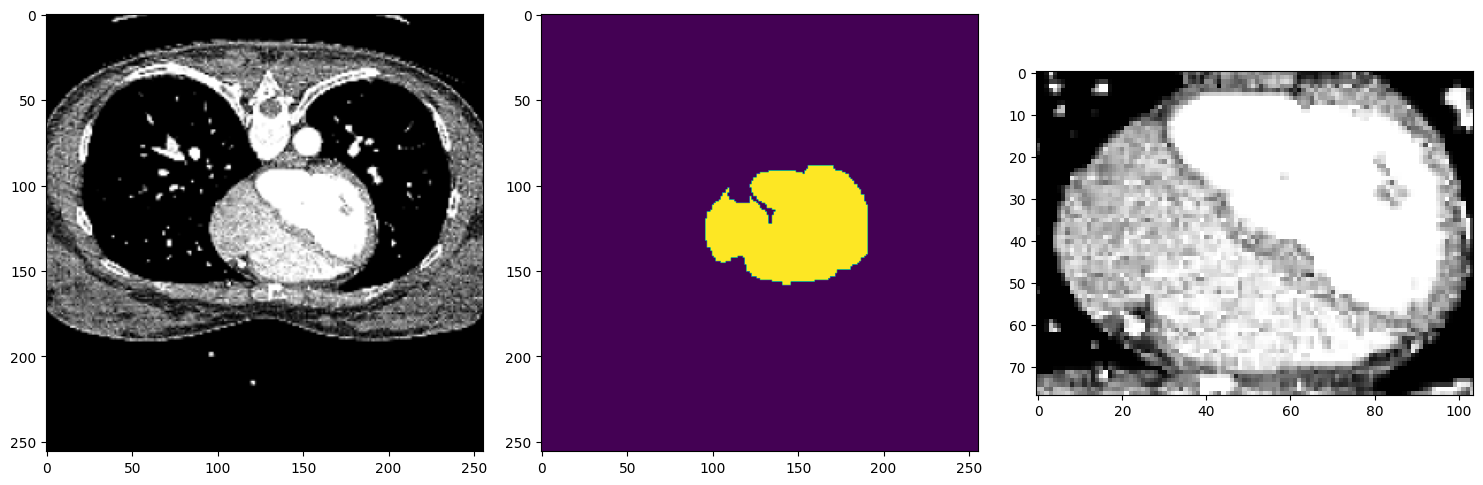

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout()
axs[0].imshow(img, cmap="gray")
axs[1].imshow(mask)
# rect = patches.Rectangle((x, y), w, h, linewidth=2, fill=False)
axs[2].imshow(img[y_min : y_max + 1, x_min : x_max + 1], cmap="gray")

In [19]:
img_path = (
    "/data1/inqlee0704/medsam/train/compressed/imgs/CT_AbdTumor_case_00049-001.png"
)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
filtered_img = anisotropic_diffusion(img, num_iter=1, kappa=10)
equalized_img = cv2.equalize_hist(img)

In [29]:
def read_and_process_image(img_path):
    gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    diffused_img = anisotropic_diffusion(gray_img, num_iter=1, kappa=20)
    equalized_img = cv2.equalizeHist(gray_img)
    merged_img = cv2.merge((gray_img, diffused_img, equalized_img))
    return merged_img

In [30]:
img = read_and_process_image(img_path)

In [31]:
img.shape

(256, 256, 3)

Text(0.5, 1.0, 'anisotropic diffusion + histogram equalization')

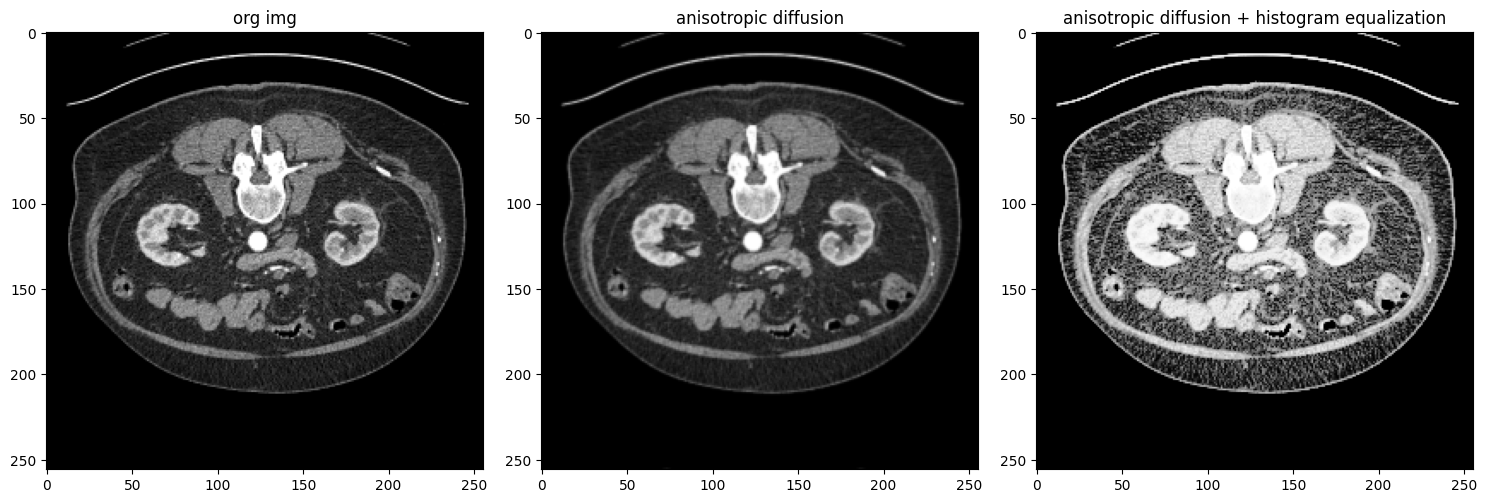

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout()
axs[0].imshow(img[:, :, 0], cmap="gray")
axs[0].set_title("org img")
axs[1].imshow(img[:, :, 1], cmap="gray")
axs[1].set_title("anisotropic diffusion")
axs[2].imshow(img[:, :, 2], cmap="gray")
axs[2].set_title("anisotropic diffusion + histogram equalization")

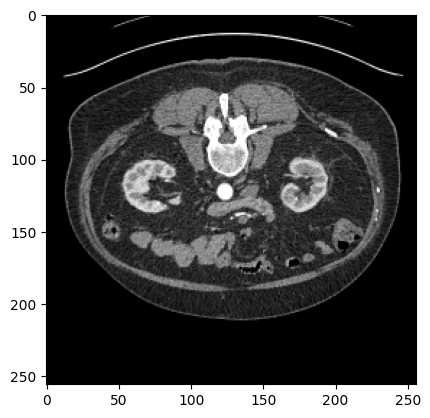

In [8]:
for batch in train_dataset:
    img = batch["image"]
    mask = batch["gt2D"]
    bbox = batch["bboxes"]
    break

In [9]:
img.shape

torch.Size([3, 256, 256])

IndexError: too many indices for tensor of dimension 3

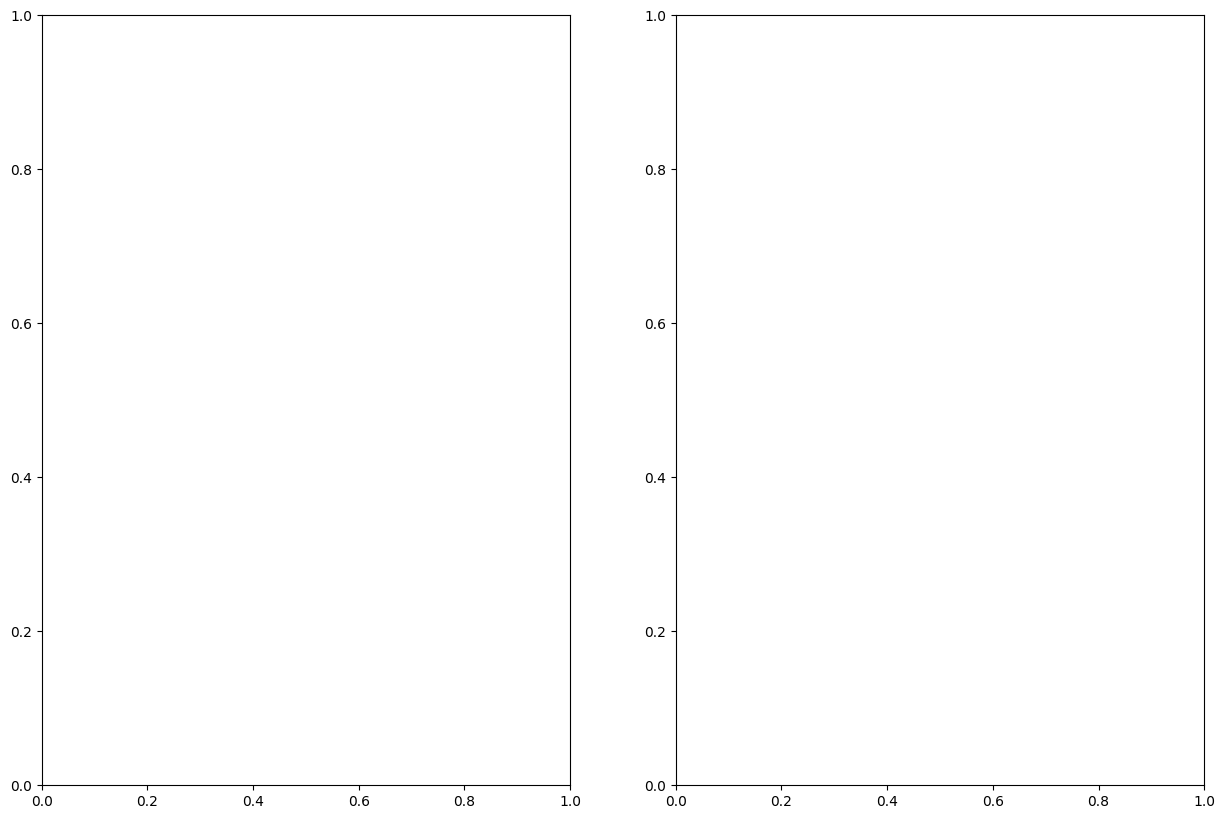

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(img[0, 0, :, :], cmap="gray")
axs[1].imshow(img[0, 0, :, :] * mask[0, 0, :, :])

In [1]:
import torch

In [16]:
state_dict = torch.load('./workdir/medsam_lite_latest.pth')

In [17]:
state_dict['model'].keys()
encoder_list = list(filter(lambda x: 'image_encoder' in x, state_dict['model'].keys()))

In [13]:

state_dict = torch.load('./workdir/efficientvit_sam_best.pth')
encoder_list - list(filter(lambda x: 'image_encoder' in x, state_dict['model'].keys()))

['image_encoder.backbone.stages.0.op_list.0.conv.weight',
 'image_encoder.backbone.stages.0.op_list.0.norm.weight',
 'image_encoder.backbone.stages.0.op_list.0.norm.bias',
 'image_encoder.backbone.stages.0.op_list.0.norm.running_mean',
 'image_encoder.backbone.stages.0.op_list.0.norm.running_var',
 'image_encoder.backbone.stages.0.op_list.0.norm.num_batches_tracked',
 'image_encoder.backbone.stages.0.op_list.1.main.conv1.conv.weight',
 'image_encoder.backbone.stages.0.op_list.1.main.conv1.norm.weight',
 'image_encoder.backbone.stages.0.op_list.1.main.conv1.norm.bias',
 'image_encoder.backbone.stages.0.op_list.1.main.conv1.norm.running_mean',
 'image_encoder.backbone.stages.0.op_list.1.main.conv1.norm.running_var',
 'image_encoder.backbone.stages.0.op_list.1.main.conv1.norm.num_batches_tracked',
 'image_encoder.backbone.stages.0.op_list.1.main.conv2.conv.weight',
 'image_encoder.backbone.stages.0.op_list.1.main.conv2.norm.weight',
 'image_encoder.backbone.stages.0.op_list.1.main.conv2.n

In [21]:
from efficientvit.sam_model_zoo import create_sam_model

efficientvit_sam = create_sam_model(
name="l0", weight_url="./l0.pt",
)
eff_encoder_list  = list(filter(lambda x: 'image_encoder' in x , list(efficientvit_sam.state_dict().keys())))

In [24]:
import torch.nn as nn 
class MedSAM_Lite(nn.Module):
    def __init__(self, image_encoder, mask_decoder, prompt_encoder):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder

    def forward(self, image, boxes):
        image_embedding = self.image_encoder(image)  # (B, 256, 64, 64)

        sparse_embeddings, dense_embeddings = self.prompt_encoder(
            points=None,
            boxes=boxes,
            masks=None,
        )
        low_res_masks, iou_predictions = self.mask_decoder(
            image_embeddings=image_embedding,  # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
            multimask_output=False,
        )  # (B, 1, 256, 256)

        return low_res_masks, iou_predictions

    @torch.no_grad()
    def postprocess_masks(self, masks, new_size, original_size):
        """
        Do cropping and resizing
        """
        # Crop
        masks = masks[:, :, : new_size[0], : new_size[1]]
        # Resize
        masks = F.interpolate(
            masks,
            size=(original_size[0], original_size[1]),
            mode="bilinear",
            align_corners=False,
        )

        return masks


In [25]:

from segment_anything.modeling import MaskDecoder, PromptEncoder, TwoWayTransformer

prompt_encoder_cfg = dict(
    embed_dim=256,
    image_embedding_size=(64, 64),
    input_image_size=(256, 256),
    mask_in_chans=16,
)
mask_decoder_cfg = dict(
    num_multimask_outputs=3,
    transformer=TwoWayTransformer(
        depth=2,
        embedding_dim=256,
        mlp_dim=2048,
        num_heads=8,
    ),
    transformer_dim=256,
    iou_head_depth=3,
    iou_head_hidden_dim=256,
)
image_encoder_cfg = dict(
    img_size=256,
    in_chans=3,
    embed_dims=[
        64,  ## (64, 256, 256)
        128,  ## (128, 128, 128)
        160,  ## (160, 64, 64)
        320,  ## (320, 64, 64)
    ],
    depths=[2, 2, 6, 2],
    num_heads=[2, 4, 5, 10],
    window_sizes=[7, 7, 14, 7],
    mlp_ratio=4.0,
    drop_rate=0.0,
    drop_path_rate=0.0,
    use_checkpoint=False,
    mbconv_expand_ratio=4.0,
    local_conv_size=3,
    layer_lr_decay=0.8,
)
medsam_lite_image_encoder = TinyViT(**image_encoder_cfg)
medsam_lite_prompt_encoder = PromptEncoder(**prompt_encoder_cfg)

medsam_lite_mask_decoder = MaskDecoder(**mask_decoder_cfg)

medsam_lite_model = MedSAM_Lite(
    image_encoder=efficientvit_sam.image_encoder,
    mask_decoder=medsam_lite_mask_decoder,
    prompt_encoder=medsam_lite_prompt_encoder,
)


print(f"MedSAM Lite size: {sum(p.numel() for p in medsam_lite_model.parameters())}")

MedSAM Lite size: 34792784


In [20]:
for a in encoder_list:
    assert a in eff_encoder_list

for a in eff_encoder_list:
    assert a in encoder_list

In [40]:
import torch
a = torch.load('inqlee/efficientvit_sam_best.pth')

In [45]:
a['optimizer']["param_groups"][-1]

{'lr': 2.657205000000001e-05,
 'betas': (0.9, 0.999),
 'eps': 1e-08,
 'weight_decay': 0.01,
 'amsgrad': False,
 'foreach': None,
 'maximize': False,
 'capturable': False,
 'differentiable': False,
 'fused': None,
 'params': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126

In [49]:
from pathlib import Path
root_dir = Path('D:/Datas/competition/cvpr2024/train/imgs')

In [59]:
a= list(root_dir.glob('CT*'))

In [60]:
import cv2
img = cv2.imread(a[0].as_posix())

In [61]:
import numpy as np
np.all(img[:,:,0] == img[:,:,1])

True

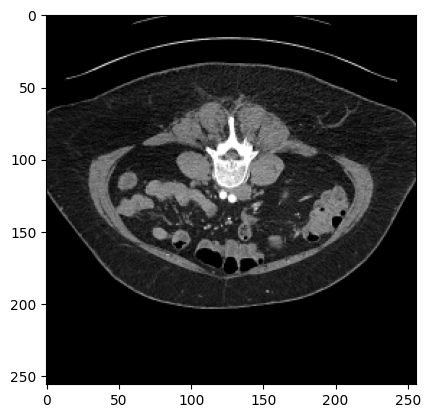

In [62]:
import matplotlib.pyplot as plt
plt.imshow(img)